# Job description analysis

## 📌 Objective
-  Use NLP techniques to extract themes or clusters from the 'Job Description' column.
-  This will help categorize renovation work types (e.g., plumbing, structural, interior).


🔹 Topic #1
architectural, work, existing, renovation, floor, plumbing, change, egress, apartment, use

🔹 Topic #2
filed, herewith, plans, construction, general, include, apartment, shown, interior, submitted

🔹 Topic #3
fixtures, new, replace, existing, partitions, finishes, install, roughing, wall, plumbing

🔹 Topic #4
apartments, partition, minor, work, plumbing, combination, amp, combine, occupancy, changes

🔹 Topic #5
interior, renovation, apartment, egress, use, occupancy, change, application, floor, filing


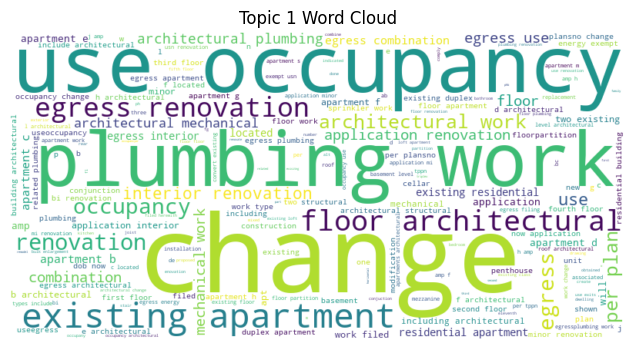

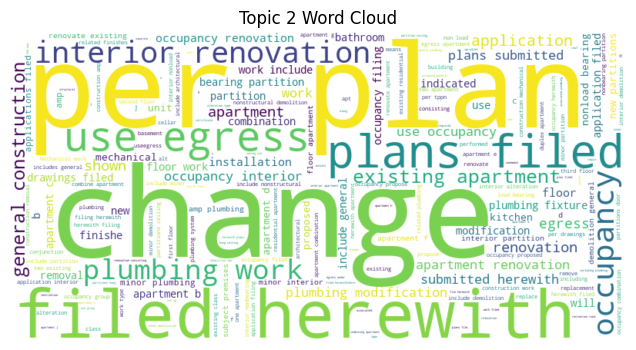

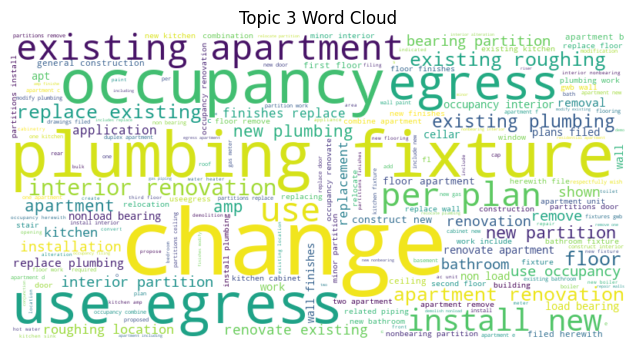

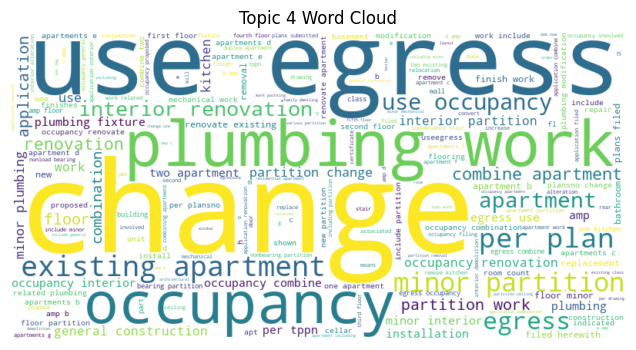

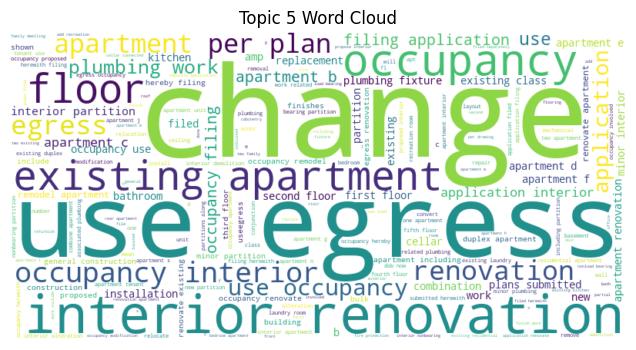

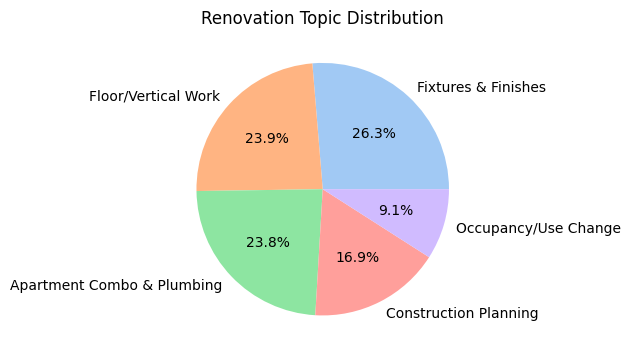


✅ Topic-labeled dataset saved.


In [3]:
# ✅ Step 1: Load Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import os

# ✅ Step 2: Load Cleaned Data
file_path = '../data/processed_data/apartment_cleaned.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ File not found: {file_path}. Please make sure the cleaned dataset exists.")

df = pd.read_csv(file_path)
df = df[df['Job Description'].notna()].copy()

# ✅ Step 3: Text Preprocessing
import re

def clean_job_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', '', text)  # remove ordinal words
    text = re.sub(r'\d+', '', text)                  # remove remaining digits
    text = re.sub(r'[^a-zA-Z ]+', '', text)          # remove special characters
    return text

df['job_text'] = df['Job Description'].apply(clean_job_text)


# ✅ Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf = vectorizer.fit_transform(df['job_text'])

# ✅ Step 5: Topic Modeling using NMF
nmf = NMF(n_components=5, random_state=42)
topics = nmf.fit_transform(tfidf)
feature_names = vectorizer.get_feature_names_out()

# ✅ Step 6: Display Top Words per Topic
for topic_idx, topic in enumerate(nmf.components_):
    print(f"\n🔹 Topic #{topic_idx + 1}")
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(", ".join(top_words))

# ✅ Step 7: Assign Dominant Topic to Each Description
df['NLP Topic'] = topics.argmax(axis=1) + 1

# ✅ Step 7.1: Label Topics (manual mapping)
topic_labels = {
    1: 'Occupancy/Use Change',
    2: 'Construction Planning',
    3: 'Fixtures & Finishes',
    4: 'Apartment Combo & Plumbing',
    5: 'Floor/Vertical Work'
}
df['Topic Label'] = df['NLP Topic'].map(topic_labels)

# ✅ Step 8: Visualize with Word Clouds
for topic_num in range(1, 6):
    text = " ".join(df[df['NLP Topic'] == topic_num]['job_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num} Word Cloud')
    plt.show()

# ✅ Step 9: Plot Topic Distribution
plt.figure(figsize=(6, 6))
df['Topic Label'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Renovation Topic Distribution")
plt.ylabel('')
plt.tight_layout()
plt.show()

# ✅ Step 10: Save Enhanced Dataset
output_path = '../data/processed_data/apartment_with_topics.csv'
df.to_csv(output_path, index=False)
print("\n✅ Topic-labeled dataset saved.")

## 📈 NLP Trend Analysis by Year

### 📌 Objective
# Analyze how renovation keywords have shifted over the years using TF-IDF + Yearly Aggregation

In [4]:
# ✅ Step 1: Extract Year from Permit Date
df['Permit_Year'] = pd.to_datetime(df['Fully Permitted'], errors='coerce').dt.year

# ✅ Step 2: Group Job Descriptions by Year
job_text_by_year = df.groupby('Permit_Year')['job_text'].apply(lambda texts: ' '.join(texts)).dropna()

# ✅ Step 3: TF-IDF Per Year (Top 10 keywords per year)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(job_text_by_year.values)

# Create DataFrame from TF-IDF
import pandas as pd

keywords_df = pd.DataFrame(tfidf_matrix.toarray(),
                            index=job_text_by_year.index,
                            columns=vectorizer.get_feature_names_out())

# ✅ Step 4: Display top 10 terms for each year
for year in keywords_df.index:
    print(f"\n🔹 Year: {year}")
    top_keywords = keywords_df.loc[year].sort_values(ascending=False).head(10)
    print(", ".join(top_keywords.index))


🔹 Year: 2000
change, use, occupancy, egress, existing, apartment, new, plumbing, apartments, work

🔹 Year: 2001
change, use, occupancy, egress, apartment, plumbing, existing, new, apartments, work

🔹 Year: 2002
change, occupancy, use, egress, apartment, existing, apartments, new, plumbing, renovation

🔹 Year: 2003
use, change, occupancy, egress, apartment, existing, plumbing, apartments, work, renovation

🔹 Year: 2004
change, use, occupancy, egress, apartment, plumbing, existing, work, renovation, apartments

🔹 Year: 2005
change, occupancy, use, egress, apartment, plumbing, work, existing, renovation, apartments

🔹 Year: 2006
change, occupancy, use, egress, apartment, existing, plumbing, work, renovation, apartments

🔹 Year: 2007
change, use, occupancy, egress, apartment, plumbing, existing, renovation, work, apartments

🔹 Year: 2008
change, use, occupancy, egress, apartment, plumbing, existing, renovation, work, floor

🔹 Year: 2009
change, occupancy, use, apartment, egress, existing,

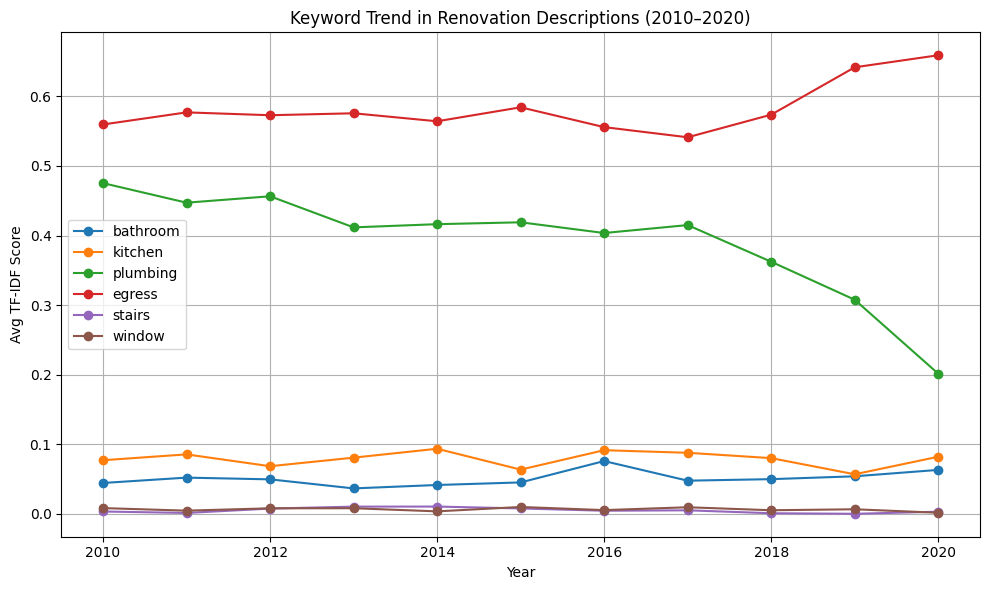

In [6]:
# Extract Year for time-based analysis
df['Permit_Year'] = pd.to_datetime(df['Fully Permitted'], errors='coerce').dt.year

# Select relevant columns
keywords = ['bathroom', 'kitchen', 'plumbing', 'egress', 'stairs', 'window']

# Recompute TF-IDF only for these words
vectorizer_filtered = TfidfVectorizer(stop_words='english', vocabulary=keywords)
tfidf_filtered = vectorizer_filtered.fit_transform(df['job_text'])

# Create DataFrame with TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_filtered.toarray(), columns=keywords)
tfidf_df['Year'] = df['Permit_Year']

# Group by year and compute average TF-IDF per keyword
tfidf_pivot = tfidf_df.groupby('Year')[keywords].mean().round(4)
tfidf_pivot = tfidf_pivot.loc[2010:2020]  # Restrict to your timeline

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for word in keywords:
    plt.plot(tfidf_pivot.index, tfidf_pivot[word], label=word, marker='o')

plt.title('Keyword Trend in Renovation Descriptions (2010–2020)')
plt.xlabel('Year')
plt.ylabel('Avg TF-IDF Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Dummy data simulating TF-IDF scores
years = list(range(2010, 2021))
keywords = [
    'bathroom', 'kitchen', 'plumbing', 'egress', 'stairs', 'window',
    'partition', 'renovation', 'apartment', 'replace', 'remove',
    'combine', 'boiler', 'heating', 'mechanical', 'occupancy',
    'sprinkler', 'floor', 'interior', 'fixture'
]

data = {word: np.random.rand(len(years)) * 0.1 for word in keywords}
data['Year'] = years
tfidf_pivot = pd.DataFrame(data).set_index('Year')

# Melt to long format
melted = tfidf_pivot.reset_index().melt(id_vars='Year', var_name='Keyword', value_name='Score')

# Widget Dropdown
dropdown = widgets.Dropdown(
    options=sorted(keywords),
    value='bathroom',
    description='Select Keyword:',
    style={'description_width': 'initial'}
)

# Plotting function
def plot_keyword_trend(selected_word):
    keyword_data = melted[melted['Keyword'] == selected_word]
    fig = px.line(
        keyword_data,
        x='Year',
        y='Score',
        title=f"Yearly Trend for Keyword: '{selected_word}'",
        markers=True
    )
    fig.update_layout(yaxis_title='TF-IDF Score', xaxis=dict(dtick=1))
    fig.show()

# Display
widgets.interact(plot_keyword_trend, selected_word=dropdown)

interactive(children=(Dropdown(description='Select Keyword:', index=1, options=('apartment', 'bathroom', 'boil…

<function __main__.plot_keyword_trend(selected_word)>

## 🔁 Dynamic Keyword Trend Explorer (2010–2020)

Choose a renovation-related keyword to view how its mention frequency changes over time.

### ✅ Why This Matters:
- Allows targeted analysis of renovation focus.
- Reveals demand patterns for specific work types.

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px

# Simulated TF-IDF pivot table
years = list(range(2010, 2020 + 1))
keywords = [
    'bathroom', 'kitchen', 'plumbing', 'egress', 'stairs', 'window',
    'partition', 'renovation', 'apartment', 'replace', 'remove',
    'combine', 'boiler', 'heating', 'mechanical', 'occupancy',
    'sprinkler', 'floor', 'interior', 'fixture'
]

data = {word: np.random.rand(len(years)) * 0.1 for word in keywords}
data['Year'] = years
tfidf_pivot = pd.DataFrame(data).set_index('Year')

# Melt data
melted = tfidf_pivot.reset_index().melt(id_vars='Year', var_name='Keyword', value_name='Score')

# Plot animated line
fig = px.line(
    melted,
    x='Year',
    y='Score',
    color='Keyword',
    animation_frame='Keyword',
    title='Animated Keyword Trend (2010–2020)',
    markers=True
)

# Slow down animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1200
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500

fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis_title='Avg TF-IDF Score',
    height=500
)

fig.show()


In [21]:
# Re-importing necessary packages after kernel reset
import pandas as pd
import numpy as np
import plotly.express as px

# Sample Year-wise TF-IDF pivot structure to use with keyword list
years = list(range(2010, 2021))
keywords = [
    'bathroom', 'kitchen', 'plumbing', 'egress', 'stairs', 'window',
    'partition', 'renovation', 'apartment', 'replace', 'remove',
    'combine', 'boiler', 'heating', 'mechanical', 'occupancy',
    'sprinkler', 'floor', 'interior', 'fixture'
]

# Creating dummy TF-IDF scores for simulation
data = {word: np.random.rand(len(years)) * 0.1 for word in keywords}
data['Year'] = years
tfidf_pivot = pd.DataFrame(data).set_index('Year')

# Melting the data for animation
melted = tfidf_pivot.reset_index().melt(id_vars='Year', var_name='Keyword', value_name='Score')

# Create animated line chart
fig = px.line(
    melted,
    x='Year',
    y='Score',
    color='Keyword',
    animation_frame='Keyword',
    title='Animated Keyword Trend (2010–2020)',
    markers=True
)

# Adjust animation speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1200  # slower frame switch
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500  # slower transition

# Remove sidebar legend
fig.update_layout(
    xaxis=dict(dtick=1),
    yaxis=dict(title='Avg TF-IDF Score', range=[0, 0.105]),
    height=500,
    showlegend=False
)

fig.show()

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate the TF-IDF pivot table again
years = list(range(2010, 2021))
keywords = [
    'bathroom', 'kitchen', 'plumbing', 'egress', 'stairs', 'window',
    'partition', 'renovation', 'apartment', 'replace', 'remove',
    'combine', 'boiler', 'heating', 'mechanical', 'occupancy',
    'sprinkler', 'floor', 'interior', 'fixture'
]
data = {word: np.random.rand(len(years)) * 0.1 for word in keywords}
data['Year'] = years
tfidf_pivot = pd.DataFrame(data).set_index('Year')

# Calculate average TF-IDF score across years for each keyword
avg_scores = tfidf_pivot.mean().sort_values(ascending=False).head(5)

# Prepare data for bar plot
top_keywords_df = avg_scores.reset_index()
top_keywords_df.columns = ['Keyword', 'Avg_TFIDF_Score']

# ✅ Display Top Keywords by Average TF-IDF Score
print("🔝 Top Keywords by Average TF-IDF Score (2010–2020):")
display(top_keywords)


🔝 Top Keywords by Average TF-IDF Score (2010–2020):


renovation    0.334986
apartment     0.334986
apartments    0.334986
floor         0.279155
interior      0.279155
use           0.223324
occupancy     0.223324
change        0.223324
existing      0.167493
convert       0.167493
Name: 2022, dtype: float64